In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(0)

In [3]:
transform=transforms.Compose([
    transforms.ToTensor(),
])

In [4]:
train_data=datasets.MNIST('data/',train=True, download=True, transform=transform)
test_data=datasets.MNIST('data/', train=False, transform=transform)

In [5]:
train_x=train_data.data
train_y=train_data.targets
test_x=test_data.data
test_y=test_data.targets
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

torch.Size([60000, 28, 28]) torch.Size([60000]) torch.Size([10000, 28, 28]) torch.Size([10000])


In [6]:
img, label=train_data[0]
print(img.shape)  # shape:(C,H,W)

torch.Size([1, 28, 28])


In [7]:
print(img.min(), img.max())

tensor(0.) tensor(1.)


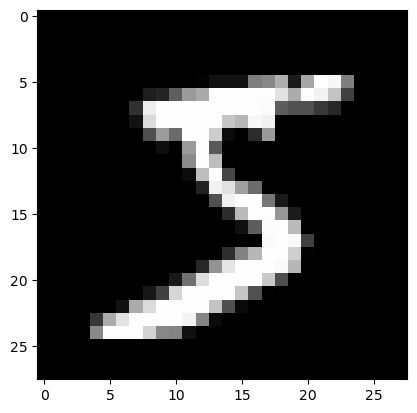

In [8]:
img2=img.permute(1,2,0)  # shape:(H,W,C)
plt.imshow(img2,cmap='gray')

In [9]:
print(label)

5


In [10]:
train_dataloader=DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader=DataLoader(test_data, batch_size=500, shuffle=False)

In [11]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()
#         self.cn1=nn.Conv2d(1, 16, 3, 1)
#         self.cn2=nn.Conv2d(16, 32, 3, 1)
#         self.dp1=nn.Dropout(0.10)
#         self.dp2=nn.Dropout(0.25)
        self.fc1=nn.Linear(196, 64)
        self.fc2=nn.Linear(64,10)

    def forward(self,x):
#         x=self.cn1(x)
#         x=F.relu(x)
#         x=self.cn2(x)
#         x=F.relu(x)
        x=F.max_pool2d(x,2)
        x=torch.flatten(x,1)
        x=self.fc1(x)
#         x=self.dp1(x)
        x=F.relu(x)
        x=self.fc2(x)
#         x=self.dp2(x)
        op=F.log_softmax(x,dim=1)
        return op

In [12]:
#device=torch.device('cuda:0')
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=ConvNet().to(device)

In [13]:
myloss=nn.NLLLoss()
myoptim=optim.Adadelta(model.parameters(),lr=0.5)

In [14]:
def train(model, device, train_dataloader, myloss, myoptim, epoch):
    model.train()

    for b_i, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        pred_prob=model(X)
        loss=myloss(pred_prob, y)

        myoptim.zero_grad()
        loss.backward()
        myoptim.step()

        if b_i % 200 ==0:
            num1=b_i*len(X)
            num2=len(train_dataloader.dataset)
            num3=100*b_i/len(train_dataloader)
            print('epoch:{} [{}/{} ({:.0f}%)]\t training loss: {:.6f}'.format(
            epoch, num1, num2, num3,loss.item()))

In [15]:
epochs=3
for epoch in range(epochs):
    train(model, device, train_dataloader, myloss, myoptim, epoch)

epoch:0 [0/60000 (0%)]	 training loss: 2.309243
epoch:0 [6400/60000 (11%)]	 training loss: 0.473541
epoch:0 [12800/60000 (21%)]	 training loss: 0.266725
epoch:0 [19200/60000 (32%)]	 training loss: 0.163164
epoch:0 [25600/60000 (43%)]	 training loss: 0.230936
epoch:0 [32000/60000 (53%)]	 training loss: 0.346424
epoch:0 [38400/60000 (64%)]	 training loss: 0.237637
epoch:0 [44800/60000 (75%)]	 training loss: 0.224784
epoch:0 [51200/60000 (85%)]	 training loss: 0.561060
epoch:0 [57600/60000 (96%)]	 training loss: 0.120448
epoch:1 [0/60000 (0%)]	 training loss: 0.176041
epoch:1 [6400/60000 (11%)]	 training loss: 0.594809
epoch:1 [12800/60000 (21%)]	 training loss: 0.196532
epoch:1 [19200/60000 (32%)]	 training loss: 0.223856
epoch:1 [25600/60000 (43%)]	 training loss: 0.075053
epoch:1 [32000/60000 (53%)]	 training loss: 0.125967
epoch:1 [38400/60000 (64%)]	 training loss: 0.222552
epoch:1 [44800/60000 (75%)]	 training loss: 0.278825
epoch:1 [51200/60000 (85%)]	 training loss: 0.094223
epoch

In [16]:
def test(model,device,test_dataloader, myloss):
    model.eval()
    loss=0
    success=0
    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            pred_prob=model(X)
            loss += myloss(pred_prob, y).item()

            pred=pred_prob.argmax(dim=1, keepdim=True)
            success += pred.eq(y.view_as(pred)).sum().item()

            num1 = loss/len(test_dataloader)
            num2=len(test_dataloader.dataset)
            num3=100*success/len(test_dataloader.dataset)
            print('Overall Loss: {:.4f}, Overall Accuracy: {}/{} ({:.2f}%)'.format(
                    num1, success, num2, num3))

In [17]:
torch.save(model.state_dict(),"data/mnist_model.pt")

In [18]:
model2=ConvNet()
model2.load_state_dict(torch.load("data/mnist_model.pt"))
model2=model2.to(device)

In [19]:
test(model2,device,test_dataloader,myloss)

Overall Loss: 0.0070, Overall Accuracy: 478/10000 (4.78%)
Overall Loss: 0.0160, Overall Accuracy: 948/10000 (9.48%)
Overall Loss: 0.0290, Overall Accuracy: 1397/10000 (13.97%)
Overall Loss: 0.0421, Overall Accuracy: 1860/10000 (18.60%)
Overall Loss: 0.0565, Overall Accuracy: 2317/10000 (23.17%)
Overall Loss: 0.0639, Overall Accuracy: 2793/10000 (27.93%)
Overall Loss: 0.0729, Overall Accuracy: 3263/10000 (32.63%)
Overall Loss: 0.0857, Overall Accuracy: 3731/10000 (37.31%)
Overall Loss: 0.0966, Overall Accuracy: 4198/10000 (41.98%)
Overall Loss: 0.1068, Overall Accuracy: 4665/10000 (46.65%)
Overall Loss: 0.1108, Overall Accuracy: 5152/10000 (51.52%)
Overall Loss: 0.1205, Overall Accuracy: 5630/10000 (56.30%)
Overall Loss: 0.1272, Overall Accuracy: 6110/10000 (61.10%)
Overall Loss: 0.1353, Overall Accuracy: 6585/10000 (65.85%)
Overall Loss: 0.1396, Overall Accuracy: 7072/10000 (70.72%)
Overall Loss: 0.1454, Overall Accuracy: 7554/10000 (75.54%)
Overall Loss: 0.1513, Overall Accuracy: 8037

In [20]:
model2=model2.to("cpu")
sample_data,sample_targets=next(iter(test_dataloader))
print(sample_data.shape)

torch.Size([500, 1, 28, 28])


In [21]:
print(sample_data[10].shape)

torch.Size([1, 28, 28])


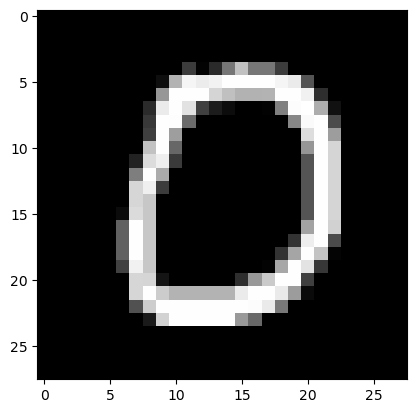

In [22]:
plt.imshow(sample_data[10][0],cmap='gray')

In [23]:
pred_label=model2(sample_data).max(dim=1)[1][10]
print(pred_label)

tensor(0)


In [24]:
print(f"Model prediction is : {pred_label}")
print(f"Ground truth is : {sample_targets[10]}")

Model prediction is : 0
Ground truth is : 0


In [25]:
def accuracy():
    temp = 0
    prediction = model2(sample_data).max(dim = 1)[1]
    for i in range(len(prediction)):
        if prediction[i] == sample_targets[i]:
            temp += 1
        
    return temp / len(prediction)

accuracy()

0.956